In [1]:
import json
import torch
import torchaudio
from transformers import Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor
from transformers import Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC
import IPython
import matplotlib.pyplot as plt

Загрузка модели

In [2]:
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [4]:
device_s = f"cuda" if torch.cuda.is_available() else "cpu"
print(f"using device {device_s}")
device = torch.device(device_s)


using device cuda


In [57]:
model = Wav2Vec2ForCTC.from_pretrained("./model")

In [58]:
model.to(device)
model.eval()

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)

Общее количество параметров модели

In [59]:
sum([param.nelement() for param in model.parameters()])

94421697

Аудио файл для тестирования

In [60]:
fpath='1.wav'

In [61]:
IPython.display.Audio(fpath)

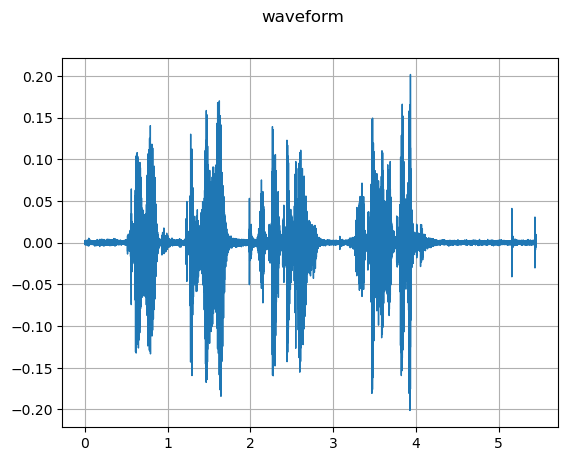

In [62]:
audio_input, sample_rate = torchaudio.load(fpath)
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)
plot_waveform(audio_input,  sample_rate)

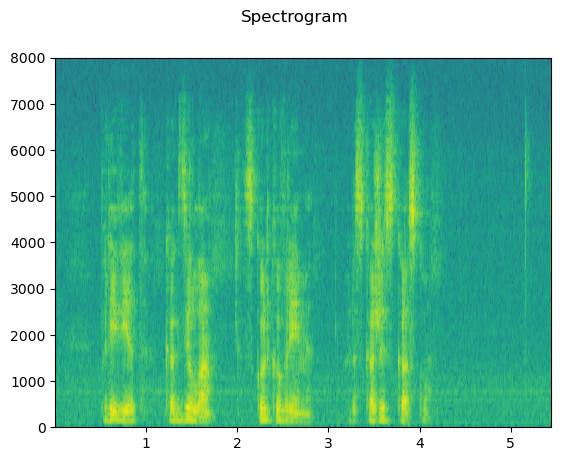

In [63]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)
plot_specgram(audio_input, sample_rate)

Загрузка аудио

In [64]:
audio_input, sample_rate = torchaudio.load(fpath)
if audio_input.shape[0]>1:
        audio_input=torch.sum(audio_input,0)/audio_input.shape[0]
        audio_input=torch.unsqueeze(audio_input,0)

audio_input=audio_input
if  sample_rate !=16000:
        audio_input= F.resample(audio_input, sample_rate,16000)
        sample_rate =16000
audio_input=torch.squeeze(audio_input)

In [65]:
input_values = processor(audio_input, sampling_rate=sample_rate, return_tensors="pt").input_values
input_values=input_values.to(device)
logits = model(input_values).logits
predicted_ids = torch.argmax(logits, dim=-1)


Индексы символов после жадного поиска

In [66]:
predicted_ids

tensor([[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64, 64, 64, 64, 64, 64, 64, 50, 64, 64,  8, 31, 64, 64, 64, 64, 64,
         54, 53, 53, 64, 64, 64, 64, 64, 64, 64, 14, 14, 64, 56, 56, 56, 56, 64,
         64, 64, 64, 64, 64, 64, 64, 59, 64, 49, 64, 64, 64, 59, 56, 56, 64, 22,
         53, 64, 64, 64, 64, 64, 23, 49, 64, 64, 64, 64, 64, 64, 56, 56, 56, 64,
         64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         26, 64, 64, 59, 45, 64, 64, 23, 23, 55, 64, 64, 59, 45, 64, 56, 56, 54,
         54, 64,  8, 53, 64, 64, 64, 64, 64, 64,  9,  7, 64, 64, 64, 56, 15, 56,
         56, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64,  8, 49, 26, 64, 64, 26, 64, 64, 59, 49, 64, 64, 64, 64,  4, 64, 31,
         64, 64, 55, 56, 26, 64, 56, 64, 59, 64, 49, 64, 64, 64, 64, 64, 64, 26,
         64, 64, 23, 23, 45, 64, 64, 64, 56, 56, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64, 64, 64, 64,

In [67]:
# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(predicted_ids[0].tolist()))

'[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] п [PAD] [PAD] р и [PAD] [PAD] [PAD] [PAD] [PAD] в е е [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] т т [PAD] | | | | [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] к [PAD] а [PAD] [PAD] [PAD] к | | [PAD] д е [PAD] [PAD] [PAD] [PAD] [PAD] л а [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] | | | [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] с [PAD] [PAD] к о [PAD] [PAD] л л ь [PAD] [PAD] к о [PAD] | | в в [PAD] р е [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] м я [PAD] [PAD] [PAD] | – | | [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] р а с [PAD] [PAD] с [PAD] [PAD] к а [PAD] [PAD] [PAD] [PAD] ж [PAD] и [PAD] [PAD] ь | с [PAD] | [PAD] к [PAD] а [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] с [PAD] [PAD] л л о [PAD] [PAD] [PAD] | | [PAD] [

Результат распознавания

In [68]:
transcription = processor.decode(predicted_ids[0])
transcription

'привет как дела сколько время – расскажиь с касло'

Извлечение акустических признаков

In [46]:
with torch.inference_mode():
    features = model.wav2vec2.feature_extractor(input_values)

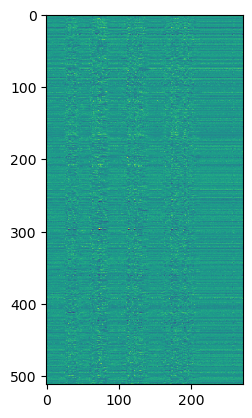

In [47]:

plt.imshow(features[0,:,:].cpu(), interpolation="nearest")


plt.show()

Вывод модели

In [50]:
input_values = processor(audio_input, sampling_rate=sample_rate, return_tensors="pt").input_values
input_values=input_values.to(device)
with torch.inference_mode():
    emission = model(input_values).logits
    
    predicted_ids = torch.argmax(emission, dim=-1)
processor.decode(predicted_ids[0])

'привет как дела сколько время – расскажиь с касло'

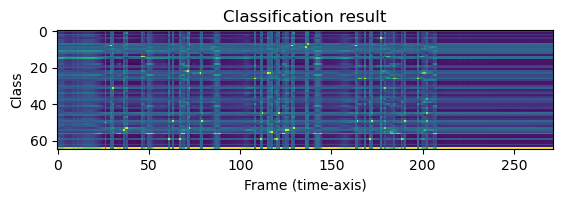

In [51]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()


In [52]:
predicted_ids

tensor([[64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64, 64, 64, 64, 64, 64, 64, 50, 64, 64,  8, 31, 64, 64, 64, 64, 64,
         54, 53, 53, 64, 64, 64, 64, 64, 64, 64, 14, 14, 64, 56, 56, 56, 56, 64,
         64, 64, 64, 64, 64, 64, 64, 59, 64, 49, 64, 64, 64, 59, 56, 56, 64, 22,
         53, 64, 64, 64, 64, 64, 23, 49, 64, 64, 64, 64, 64, 64, 56, 56, 56, 64,
         64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         26, 64, 64, 59, 45, 64, 64, 23, 23, 55, 64, 64, 59, 45, 64, 56, 56, 54,
         54, 64,  8, 53, 64, 64, 64, 64, 64, 64,  9,  7, 64, 64, 64, 56, 15, 56,
         56, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         64,  8, 49, 26, 64, 64, 26, 64, 64, 59, 49, 64, 64, 64, 64,  4, 64, 31,
         64, 64, 55, 56, 26, 64, 56, 64, 59, 64, 49, 64, 64, 64, 64, 64, 64, 26,
         64, 64, 23, 23, 45, 64, 64, 64, 56, 56, 64, 64, 64, 64, 64, 64, 64, 64,
         64, 64, 64, 64, 64,

Поиск по лучу 

In [53]:
simvol={'m': 0,
 'ё': 1,
 'e': 2,
 'i': 3,
 'ж': 4,
 '‑': 5,
 's': 6,
 'я': 7,
 'р': 8,
 'м': 9,
 'н': 10,
 '«': 11,
 'й': 12,
 'g': 13,
 'т': 14,
 '–': 15,
 'k': 16,
 'z': 17,
 '—': 18,
 'з': 19,
 "'": 20,
 'a': 21,
 'д': 22,
 'л': 23,
 '»': 24,
 'ч': 25,
 'с': 26,
 'б': 27,
 'h': 28,
 'c': 29,
 '(': 30,
 'и': 31,
 'l': 32,
 'щ': 33,
 'ф': 34,
 'o': 35,
 'ш': 36,
 'у': 37,
 'х': 38,
 'г': 39,
 'ц': 40,
 '…': 41,
 'ы': 42,
 'b': 43,
 'x': 44,
 'о': 45,
 'э': 46,
 'ъ': 47,
 'p': 48,
 'а': 49,
 'п': 50,
 'ю': 51,
 '−': 52,
 'е': 53,
 'в': 54,
 'ь': 55,
  '|': 56,      
 'r': 57,
 't': 58,
 'к': 59,
 ')': 60,
 'f': 61,
 'n': 62,
  '[UNK]': 63,
 '[PAD]': 64}
labels=list(simvol.keys())

In [54]:
from pyctcdecode import build_ctcdecoder

In [55]:
decoder = build_ctcdecoder(
    labels,
    kenlm_model_path=None,  # either .arpa or .bin file
    alpha=0.5,  # tuned on a val set
    beta=1.0,  # tuned on a val set
)

In [56]:
text = decoder.decode( emission[0,:,:].cpu().detach().numpy())
text

'привет как дела сколько время – расскажит с касло'

In [41]:
hotwords=['мама','мыла','раму','расскажи', 'сказку']

In [42]:
decoder.decode(logits[0,:,:].cpu().detach().numpy(),hotwords=hotwords,
hotword_weight=10.0,)

'привет как дела сколько время – расскажи с касло'